## Импорт библиотек и датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [47]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 25000], [0, 25000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

## Сводная информация по датасэту

In [6]:
train.head()

User_ID Product_ID Gender    Age  Occupation City_Category  \
0  1004085  P00075742      F  26-35           6             A   
1  1005491  P00234842      M  18-25           7             A   
2  1003499  P00220142      M  26-35           3             A   
3  1000097  P00211242      F  36-45           3             C   
4  1005802  P00327142      F  26-35           0             A   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          1               0                   8   
1                          1               0                   5   
2                          2               0                   1   
3                          3               0                   8   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                14.0                 NaN      7803  
1                 6.0                16.0      6903  
2                15.0                 NaN     15773  
3                12.0                 NaN      8116  
4                15.0                 NaN      6144

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     80000 non-null  int64  
 1   Product_ID                  80000 non-null  object 
 2   Gender                      80000 non-null  object 
 3   Age                         80000 non-null  object 
 4   Occupation                  80000 non-null  int64  
 5   City_Category               80000 non-null  object 
 6   Stay_In_Current_City_Years  80000 non-null  object 
 7   Marital_Status              80000 non-null  int64  
 8   Product_Category_1          80000 non-null  int64  
 9   Product_Category_2          54892 non-null  float64
 10  Product_Category_3          24331 non-null  float64
 11  Purchase                    80000 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 7.3+ MB


In [8]:
train.describe()

User_ID    Occupation  Marital_Status  Product_Category_1  \
count  8.000000e+04  80000.000000    80000.000000        80000.000000   
mean   1.003023e+06      8.086863        0.409388            5.388463   
std    1.728959e+03      6.536459        0.491724            3.922793   
min    1.000001e+06      0.000000        0.000000            1.000000   
25%    1.001503e+06      2.000000        0.000000            1.000000   
50%    1.003067e+06      7.000000        0.000000            5.000000   
75%    1.004478e+06     14.000000        1.000000            8.000000   
max    1.006040e+06     20.000000        1.000000           20.000000   

       Product_Category_2  Product_Category_3      Purchase  
count        54892.000000        24331.000000  80000.000000  
mean             9.851873           12.676421   9243.933162  
std              5.079163            4.109343   5021.298356  
min              2.000000            3.000000     12.000000  
25%              5.000000            9.000000   5679.750000  
50%              9.000000           14.000000   8039.000000  
75%             15.000000           16.000000  12046.000000  
max             18.000000           18.000000  23961.000000

#### Целевая переменная

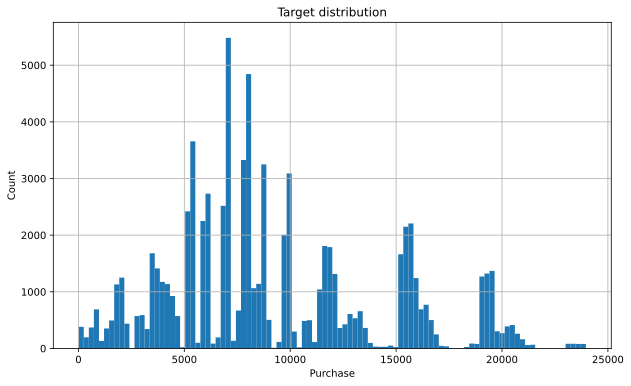

In [9]:
plt.figure(figsize = (10, 6))

train['Purchase'].hist(bins=100)
plt.ylabel('Count')
plt.xlabel('Purchase')

plt.title('Target distribution')
plt.show()

Распределение нашей переменной далеко от нормального. На графике видно как будто 6-7 колоколов. И тот что в интервале от 5000 до 10000 с очень большой волатильностью.

## Исследование фичей

### Пропуски данных

In [10]:
train.isna().sum()

User_ID                           0
Product_ID                        0
Gender                            0
Age                               0
Occupation                        0
City_Category                     0
Stay_In_Current_City_Years        0
Marital_Status                    0
Product_Category_1                0
Product_Category_2            25108
Product_Category_3            55669
Purchase                          0
dtype: int64

Пропущенны данные в фичах Product_Category_2 и в Product_Category_3. Пока с ними ничего не делаем. Разберемся позже

## Типы данных

In [11]:
train.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

У нас есть три типа данных int64, float64 и object. Разберемся сначала с данными типа Object. 

#### Product_ID

In [12]:
train['Product_ID'].describe()

count         80000
unique         3256
top       P00265242
freq            272
Name: Product_ID, dtype: object

Не все значения в этом поле уникальны. Похоже что это какие-то конкретные товары, которые покупают в BlackFriday, пока не понятно что этими данными сделать. Вернемся к ним позже.

#### Gender

In [13]:
train['Gender'].describe()

count     80000
unique        2
top           M
freq      60068
Name: Gender, dtype: object

Тут два значения F и M. Можем заменить на числовые значения 1 и 0.

In [14]:
def map_gender(gender):
    if gender == 'M':
        return 1
    else:
        return 0
    
train['Gender'] = train['Gender'].apply(map_gender)

#### Age

In [15]:
train['Age'].describe()

count     80000
unique        7
top       26-35
freq      32067
Name: Age, dtype: object

In [16]:
print(set(train['Age']))

{'51-55', '36-45', '46-50', '0-17', '26-35', '18-25', '55+'}


В столбце Age указаны возрастные интервалы. Всего 7 штук. Заменим их на числа от 0 до 6

In [17]:
def map_age(age):
    if age == '0-17':
        return 0
    elif age == '18-25':
        return 1
    elif age == '26-35':
        return 2
    elif age == '36-45':
        return 3
    elif age == '46-50':
        return 4
    elif age == '51-55':
        return 5
    else:
        return 6
    
train['Age'] = train['Age'].apply(map_age)

#### City_Category 

In [18]:
train['City_Category'].describe()

count     80000
unique        3
top           B
freq      33767
Name: City_Category, dtype: object

In [19]:
print(set(train['City_Category']))

{'A', 'C', 'B'}


Заменяем значения по той же аналогии

In [20]:
def map_city(city):
    if city == 'A':
        return 0
    elif city == 'B':
        return 1
    else:
        return 2
    
train['City_Category'] = train['City_Category'].apply(map_city)

#### Stay_In_Current_City_Years

In [21]:
print(set(train['Stay_In_Current_City_Years']))

{'2', '0', '4+', '1', '3'}


In [22]:
def map_stay(years):
    if years == '0':
        return 0
    elif years == '1':
        return 1
    elif years == '2':
        return 2
    elif years == '3':
        return 3
    else:
        return 4
    
train['Stay_In_Current_City_Years'] = train['Stay_In_Current_City_Years'].apply(map_stay)

In [23]:
train.dtypes

User_ID                         int64
Product_ID                     object
Gender                          int64
Age                             int64
Occupation                      int64
City_Category                   int64
Stay_In_Current_City_Years      int64
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

#### Product_ID и User_ID

Product_ID так и не придумал как можно использовать в модели. Вместе с User_ID решил удалить из датасэта. 

In [24]:
train = train.drop('Product_ID', axis = 1)
train = train.drop('User_ID', axis = 1)

#### Посмотрим что осталось в датасэте и как это теперь выглядит.


In [25]:
train.head(5)

Gender  Age  Occupation  City_Category  Stay_In_Current_City_Years  \
0       0    2           6              0                           1   
1       1    1           7              0                           1   
2       1    2           3              0                           2   
3       0    3           3              2                           3   
4       0    2           0              0                           4   

   Marital_Status  Product_Category_1  Product_Category_2  Product_Category_3  \
0               0                   8                14.0                 NaN   
1               0                   5                 6.0                16.0   
2               0                   1                15.0                 NaN   
3               0                   8                12.0                 NaN   
4               0                   8                15.0                 NaN   

   Purchase  
0      7803  
1      6903  
2     15773  
3      8116  
4      6144

Разберемся теперь с Product_Category_2. Посмотрим какие там есть значения

#### Product_Category_2 и Product_Category_3

In [26]:
print(set(train['Product_Category_2']))

{nan, nan, 2.0, nan, 4.0, 5.0, 6.0, nan, 8.0, nan, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 9.0, 18.0, 3.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 7.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

Можем предположить, что значение NaN стоит либо там где нет информации о категории либо если в данной категории не покупался товар. Возьмем за основу второе предположение и заменим все Nan на значение 0

In [27]:
train = train.fillna(0)

Еще раз проверяем на полноту данных:

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Gender                      80000 non-null  int64  
 1   Age                         80000 non-null  int64  
 2   Occupation                  80000 non-null  int64  
 3   City_Category               80000 non-null  int64  
 4   Stay_In_Current_City_Years  80000 non-null  int64  
 5   Marital_Status              80000 non-null  int64  
 6   Product_Category_1          80000 non-null  int64  
 7   Product_Category_2          80000 non-null  float64
 8   Product_Category_3          80000 non-null  float64
 9   Purchase                    80000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 6.1 MB


Все в порядке, можем идти дальше

## EDA

### Корреляция 

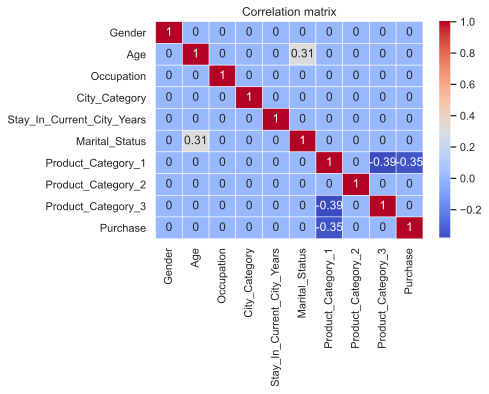

In [29]:
plt.figure(figsize = (6,4))

sns.set(font_scale=1)

corr_matrix = train.corr()
corr_matrix = np.round(corr_matrix, 3)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Заметной корреляции признаков нет.

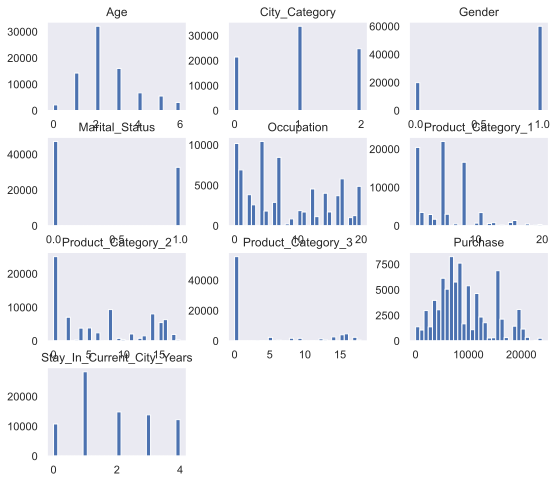

In [30]:
train.hist(figsize=(9,8), bins=30, grid=False);

In [48]:
sns.barplot('Gender', 'Purchase', train = data)
plt.show()

NameError: name 'data' is not defined

### Разделяем train на тренировочный и валидационный сэты.

In [31]:
train_df = train.drop('Purchase', axis = 1)
train_df.head(5)

Gender  Age  Occupation  City_Category  Stay_In_Current_City_Years  \
0       0    2           6              0                           1   
1       1    1           7              0                           1   
2       1    2           3              0                           2   
3       0    3           3              2                           3   
4       0    2           0              0                           4   

   Marital_Status  Product_Category_1  Product_Category_2  Product_Category_3  
0               0                   8                14.0                 0.0  
1               0                   5                 6.0                16.0  
2               0                   1                15.0                 0.0  
3               0                   8                12.0                 0.0  
4               0                   8                15.0                 0.0

In [32]:
y = pd.DataFrame(train['Purchase'], columns = ['Purchase'])
y.head(5)

Purchase
0      7803
1      6903
2     15773
3      8116
4      6144

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, y, test_size = 0.3)

## Случайный лес

In [54]:
rf = RandomForestRegressor()

In [55]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [56]:
y_pred = rf.predict(X_valid)

In [57]:
check_test = pd.DataFrame({'y_valid': y_valid['Purchase'], 'y_pred': y_pred.flatten()})
check_test['Error'] = check_test['y_valid'] - check_test['y_pred']
check_test.head(3)

y_valid        y_pred        Error
63156     9947   7532.887701  2414.112299
64295     5321   6116.596913  -795.596913
12820    15366  12833.689833  2532.310167

In [58]:
evaluate_preds(check_test['y_valid'], check_test['y_pred'])

R2:	0.615
RMSE:	3106.623
MSE:	9651103.492


r2 > 0.7 нам подходит. Теперь доработаем test датасэт по аналогии с train и запустим наш предикт по нему.

## GradientBossting

In [39]:
gb = GradientBoostingRegressor(criterion='mse',
                                max_depth=5,
                                min_samples_leaf=10,
                                random_state=88,  
                                n_estimators=100)

In [40]:
gb.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=10,
                          random_state=88)

In [41]:
y_pred = gb.predict(X_valid)

In [42]:
check_test = pd.DataFrame({'y_valid': y_valid['Purchase'], 'y_pred': y_pred.flatten()})
check_test['Error'] = check_test['y_valid'] - check_test['y_pred']
check_test.head(3)

y_valid        y_pred        Error
63156     9947   7534.003819  2412.996181
64295     5321   6327.179727 -1006.179727
12820    15366  12475.589768  2890.410232

In [53]:
evaluate_preds(check_test['y_valid'], check_test['y_pred'])

R2:	0.665
RMSE:	2901.051
MSE:	8416096.806


Градиентный бустинг дает чуть лучший итоговый результат. Остановимся на этой модели.

In [49]:
train['Product_Category_3'].mean()

3.855375

In [50]:
train['Product_Category_2'].mean()

6.7598625

In [51]:
train['Product_Category_1'].mean()

5.3884625

## Подготовка test датасэта. Повторяем все изменения из train сэта

In [44]:
test.head(3)

User_ID Product_ID Gender    Age  Occupation City_Category  \
0  1002118  P00108542      M  26-35          14             A   
1  1002476  P00086442      M  51-55          12             C   
2  1005220  P00248442      M  26-35           7             B   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          1               1                   5   
1                          1               1                   8   
2                         4+               0                   3   

   Product_Category_2  Product_Category_3  
0                 8.0                14.0  
1                13.0                15.0  
2                 4.0                 NaN

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     20000 non-null  int64  
 1   Product_ID                  20000 non-null  object 
 2   Gender                      20000 non-null  object 
 3   Age                         20000 non-null  object 
 4   Occupation                  20000 non-null  int64  
 5   City_Category               20000 non-null  object 
 6   Stay_In_Current_City_Years  20000 non-null  object 
 7   Marital_Status              20000 non-null  int64  
 8   Product_Category_1          20000 non-null  int64  
 9   Product_Category_2          13598 non-null  float64
 10  Product_Category_3          6064 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 1.7+ MB


Удаляем Healthcare_1 и переименуем Helthcare_2 в Healthcare_2

In [59]:
test['Gender'] = test['Gender'].apply(map_gender)
test['Age'] = test['Age'].apply(map_age)
test['City_Category'] = test['City_Category'].apply(map_city)
test['Stay_In_Current_City_Years'] = test['Stay_In_Current_City_Years'].apply(map_stay)
test = test.drop('Product_ID', axis = 1)
test = test.drop('User_ID', axis = 1)

In [61]:
test = test.fillna(0)

In [62]:
test.head(5)

Gender  Age  Occupation  City_Category  Stay_In_Current_City_Years  \
0       1    2          14              0                           1   
1       1    5          12              2                           1   
2       1    2           7              1                           4   
3       1    1           0              2                           2   
4       1    2          14              1                           2   

   Marital_Status  Product_Category_1  Product_Category_2  Product_Category_3  
0               1                   5                 8.0                14.0  
1               1                   8                13.0                15.0  
2               0                   3                 4.0                 0.0  
3               0                   8                 0.0                 0.0  
4               0                   5                 0.0                 0.0

## Делаем предсказание на test сэте.

In [63]:
y_pred_test = gb.predict(test)

In [64]:
y_pred_test

array([6262.78423027, 7673.89488359, 9431.65443967, ..., 6438.90570919,
       7243.01441411, 6544.28002186])

In [65]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

Id  Purchase
0   0      9000
1   1      9000
2   2      9000
3   3      9000
4   4      9000

In [68]:
submit['Purchase'] = y_pred_test
submit.head()

Id     Purchase
0   0  6262.784230
1   1  7673.894884
2   2  9431.654440
3   3  7587.186480
4   4  6118.017460

In [69]:
submit.to_csv('khabibulin_submit_gb_2.csv', index=False)